In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
from operator import add
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc

from ipynb.fs.full.GenerateData import generatedata
from ipynb.fs.full.AnalysisPartFunctions import initialize_parameters,initialize_dicts,calc_prior_mean,calc_post_mean,calc_post_sd,calc_Phi,calc_L,calc_component_derivs,calc_gradients,update_parameters, predict_choice

In [2]:
random.seed(110)

**(a) Generate data**

In [3]:
data = pd.DataFrame(generatedata())

In [4]:
data.head()

,index,id,name,first,last,sex,race,dob,age,age_cat,...,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,release
0,0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1
1,1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0
2,2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,...,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),1
3,3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,...,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN,0
4,4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0


check how many released/remanded

In [5]:
data.release.value_counts()

1    6800
0    4942
Name: release, dtype: int64

**(b) Create dummy variables for categorical variables**

In [6]:
sex_dummies = pd.get_dummies(data['sex'])
race_dummies = pd.get_dummies(data['race'])
age_dummies = pd.get_dummies(data['age_cat'])

data['sex_1_male'] = sex_dummies['Male']
data['African_American']=race_dummies['African-American']
data['Asian']=race_dummies['Asian']
data['Caucasian']=race_dummies['Caucasian']
data['Hispanic'] = race_dummies['Hispanic']
data['Native_American']=race_dummies['Native American']
data['race_Other']=race_dummies['Other']
data['Greater_45']=age_dummies['Greater than 45']
data['25_45']=age_dummies['25 - 45']
data['Less_25']=age_dummies['Less than 25']

In [7]:
data.columns

Index(['index', 'id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age',
       'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date', 'decile_score', 'score_text', 'violent_recid',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_days_from_compas', 'c_arrest_date',
       'c_offense_date', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'num_r_cases', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'release',
       'sex_1_male', 'African_American', 'Asian', 'Caucasian', 'Hispanic',
       'Native_American', 'race_Other', 'Greater_45', '25_45', 'Less_25'],
      dtype='object')

**(c) Split data into training & test**

In [8]:
# select out relevant data & generate the train and test data

# train / test
features = ['decile_score','Less_25','25_45','Greater_45','sex_1_male','African_American','Caucasian','is_violent_recid','juv_fel_count']
X = data[features]
y = data['release']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=120)

risk_assess_train = X_train['decile_score']
X_train = X_train.drop(['decile_score'],axis=1)

risk_assess_test = X_test['decile_score'].tolist()
X_test = X_test.drop(['decile_score'],axis=1)
y_test = y_test.tolist()

Define variables for analysis without penalties

In [9]:
initial_parameters = initialize_parameters(X_train,1,10)
derivatives,grads = initialize_dicts()

In [10]:
initial_parameters

{'B': array([[0.09348775],
        [0.00869119],
        [0.08813534],
        [0.07249234],
        [0.08345957],
        [0.06469335],
        [0.02777332],
        [0.07446234]]),
 'b': 5.530548327250209,
 'q': 0.13408894502472324,
 'sd_prior': 9.887922138029468,
 'tau': 8}

In [11]:
parameters = {"B": initial_parameters['B'],
              "b": initial_parameters['b'],
              "q" : initial_parameters['q'],
              "sd_prior" : initial_parameters['sd_prior'],
              "tau" : initial_parameters['tau']}
parameters

{'B': array([[0.09348775],
        [0.00869119],
        [0.08813534],
        [0.07249234],
        [0.08345957],
        [0.06469335],
        [0.02777332],
        [0.07446234]]),
 'b': 5.530548327250209,
 'q': 0.13408894502472324,
 'sd_prior': 9.887922138029468,
 'tau': 8}

In [46]:
X = X_train
Y = y_train.tolist()
mu_ra = risk_assess_train.tolist()
num_int = 100
learning_rate = 0.2
Theta = [1,2,3,4,5,6,7,8,9,10]

# create containers for the optimized parameters for each 
param_info = {}
for i in range(len(Theta)):
    th = Theta[i]
    param_info[th]={}
    param_info[th]['auc']=[]
    param_info[th]['loss']=[]
    param_info[th]['best_params']={}
    param_info[th]['best_params']['B']=[0]*X.shape[1]
    param_info[th]['best_params']['b']=0
    param_info[th]['best_params']['q']=0
    param_info[th]['best_params']['sd_prior']=0
    param_info[th]['best_params']['tau']=0

# learn model
for theta in Theta: 
    
    # reset the 'parameters' dict to the initial parameters values
    parameters = {"B": initial_parameters['B'],
                  "b": initial_parameters['b'],
                  "q" : initial_parameters['q'],
                  "sd_prior" : initial_parameters['sd_prior'],
                  "tau" : initial_parameters['tau']}
    
    loss = []
    j = 0

    #print("params: ",parameters)
    
    while j < num_int:
        
        mu_prior = calc_prior_mean(X, parameters)
        mu_post = calc_post_mean(mu_prior, mu_ra, parameters, theta)
        sd_post =calc_post_sd(mu_prior, mu_ra, parameters, theta)
        Phi = calc_Phi(mu_post, sd_post, parameters)
        L = calc_L(Phi, Y)
        loss.append(L)

        derivatives = calc_component_derivs(X,parameters, derivatives, theta, mu_prior,mu_ra,mu_post,sd_post,Phi,Y)
        grads = calc_gradients(X,grads,derivatives)
        parameters = update_parameters(parameters, grads, learning_rate)
        #print("intermediate params: ",parameters)

        if j%1==0:
            print("loss: ",L)
        j+=1
    
    param_info[theta]['loss'] = loss
    #print("optim params: ", parameters)
    
    # test these parameters to calculate auc and compare to others
    Phi_test = predict_choice(X_test,risk_assess_test,parameters,theta)
    
    # calculate the auc with the converged weights
    auc = roc_auc_score(y_test,Phi_test)
    param_info[theta]['auc'] = auc
    #print("auc: ",auc)
    
    # if there is an improvement in the AUC, update the 'best_params' with those weights
    param_info[theta]['best_params']['B'] = parameters['B']
    param_info[theta]['best_params']['b'] = parameters['b']
    param_info[theta]['best_params']['q'] = parameters['q']
    param_info[theta]['best_params']['sd_prior'] = parameters['sd_prior']
    param_info[theta]['best_params']['tau'] = parameters['tau']
        

loss:  0.9113872050153108
loss:  0.8323030398218957
loss:  0.7889504182143707
loss:  0.7625032216713432
loss:  0.745029478754179
loss:  0.7328475962964119
loss:  0.7239816780677187
loss:  0.7173047758284635
loss:  0.7121346492294108
loss:  0.708037898176813
loss:  0.7047280275866644
loss:  0.7020092133369471
loss:  0.6997437358112448
loss:  0.6978323271765724
loss:  0.6962018845698993
loss:  0.694797548582273
loss:  0.6935774564685347
loss:  0.6925091830025263
loss:  0.6915672742309904
loss:  0.6907315056103487
loss:  0.6899856304024151
loss:  0.6893164661969224
loss:  0.6887132186685858
loss:  0.6881669744059823
loss:  0.6876703159718185
loss:  0.6872170265049891
loss:  0.6868018607178369
loss:  0.686420365683995
loss:  0.6860687393559869
loss:  0.6857437179531624
loss:  0.6854424856417005
loss:  0.6851626015745802
loss:  0.6849019405576036
loss:  0.6846586444922095
loss:  0.6844310824002913
loss:  0.6842178173297229
loss:  0.6840175788107835
loss:  0.6838292398168505
loss:  0.6836517

loss:  0.6562631176435358
loss:  0.6550440105136305
loss:  0.6541002772298545
loss:  0.6533553935349251
loss:  0.6528142632536322
loss:  0.6524193479969471
loss:  0.6521438019527735
loss:  0.6519659887040357
loss:  0.6518683690504736
loss:  0.6518366497704954
loss:  0.6518591266089574
loss:  0.6519261731940175
loss:  0.6520298405608109
loss:  0.6521635411977966
loss:  0.6523217981806804
loss:  0.6525000447896575
loss:  0.6526944635492453
loss:  0.6529018562494349
loss:  0.653119538462189
loss:  0.6533452535349944
loss:  0.6535771021546355
loss:  0.6538134844220034
loss:  0.6540530520274562
loss:  0.6542946686193966
loss:  0.654537376846128
loss:  0.6547803708571343
loss:  0.6550229732869869
loss:  0.6552646159343767
loss:  0.6555048234975834
loss:  0.6557431998469168
loss:  0.6559794164093743
loss:  0.6562132023177699
loss:  0.656444336037614
loss:  0.656672638235669
loss:  0.6568979656941776
loss:  0.6571202061077932
loss:  0.6573392736284009
loss:  0.6575551050435434
loss:  0.6577676

loss:  0.6068760536551892
loss:  0.6078877343822312
loss:  0.6088854718857893
loss:  0.6098677958129606
loss:  0.610833595814
loss:  0.6117820561025418
loss:  0.6127126018906791
loss:  0.6136248554318923
loss:  0.6145185998662274
loss:  0.6153937494220568
loss:  0.6162503248137148
loss:  0.6170884328979747
loss:  0.6179082498320022
loss:  0.6187100071165389
loss:  0.6194939800228537
loss:  0.6202604779933564
loss:  0.6210098366795977
loss:  0.6217424113411011
loss:  0.6224585713774003
loss:  0.6231586958048316
loss:  0.6238431695222357
loss:  0.6245123802356681
loss:  0.6251667159351997
loss:  0.6258065628332101
loss:  0.6264323036896584
loss:  0.6270443164614478
loss:  0.6276429732234776
loss:  0.6282286393171181
loss:  0.6288016726891934
loss:  0.6293624233903713
loss:  0.6299112332064147
loss:  0.630448435400813
loss:  0.6309743545493587
loss:  0.6314893064516823
loss:  0.6319935981059697
loss:  0.6324875277358228
loss:  0.6329713848598562
loss:  0.6334454503959556
loss:  0.63390999

loss:  0.6217424113411011
loss:  0.6224585713774003
loss:  0.6231586958048316
loss:  0.6238431695222357
loss:  0.6245123802356681
loss:  0.6251667159351997
loss:  0.6258065628332101
loss:  0.6264323036896584
loss:  0.6270443164614478
loss:  0.6276429732234776
loss:  0.6282286393171181
loss:  0.6288016726891934
loss:  0.6293624233903713
loss:  0.6299112332064147
loss:  0.630448435400813
loss:  0.6309743545493587
loss:  0.6314893064516823
loss:  0.6319935981059697
loss:  0.6324875277358228
loss:  0.6329713848598562
loss:  0.6334454503959556
loss:  0.6339099967933144
loss:  0.6343652881869104
loss:  0.6348115805692367
loss:  0.6352491219755825
loss:  0.6356781526790319
loss:  0.6360989053929056
loss:  0.6365116054777733
loss:  0.6369164711512546
loss:  0.6373137136989563
loss:  0.6377035376850804
loss:  0.6380861411617434
loss:  0.6384617158758747
loss:  0.6388304474730873
loss:  0.6391925156979622
loss:  0.6395480945900142
loss:  0.6398973526753793
loss:  0.6402404531535135
loss:  0.6405

In [47]:
param_info

{1: {'auc': 0.4450036706606669,
  'loss': [0.9113872050153108,
   0.8323030398218957,
   0.7889504182143707,
   0.7625032216713432,
   0.745029478754179,
   0.7328475962964119,
   0.7239816780677187,
   0.7173047758284635,
   0.7121346492294108,
   0.708037898176813,
   0.7047280275866644,
   0.7020092133369471,
   0.6997437358112448,
   0.6978323271765724,
   0.6962018845698993,
   0.694797548582273,
   0.6935774564685347,
   0.6925091830025263,
   0.6915672742309904,
   0.6907315056103487,
   0.6899856304024151,
   0.6893164661969224,
   0.6887132186685858,
   0.6881669744059823,
   0.6876703159718185,
   0.6872170265049891,
   0.6868018607178369,
   0.686420365683995,
   0.6860687393559869,
   0.6857437179531624,
   0.6854424856417005,
   0.6851626015745802,
   0.6849019405576036,
   0.6846586444922095,
   0.6844310824002913,
   0.6842178173297229,
   0.6840175788107835,
   0.6838292398168505,
   0.683651797401716,
   0.6834843563521995,
   0.6833261153287604,
   0.6831763550656035,

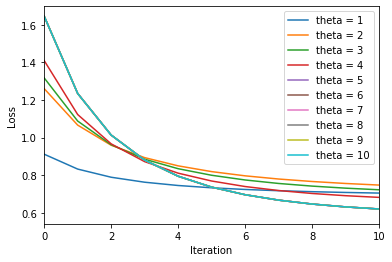

In [48]:
# plot loss over theta
for i in param_info:
    plt.plot(param_info[i]['loss'],label='theta = %s' % (i))
    plt.xlim([0.0, 10.0])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

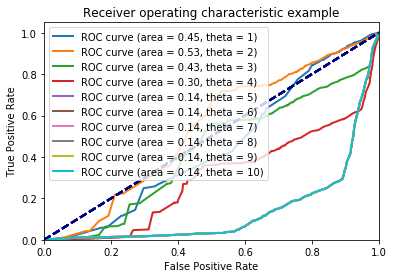

In [49]:
for i in param_info:
    y_pred = predict_choice(X_test,risk_assess_test,param_info[i]['best_params'],best_theta=i)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f, theta = %s)' % (roc_auc,i))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="upper left")

(array([2.302e+03, 1.784e+03, 1.044e+03, 1.325e+03, 7.850e+02, 1.061e+03,
        4.940e+02, 9.000e+00, 0.000e+00, 2.000e+00]),
 array([4.61157645, 4.93188234, 5.25218824, 5.57249413, 5.89280002,
        6.21310592, 6.53341181, 6.85371771, 7.1740236 , 7.49432949,
        7.81463539]),
 <a list of 10 Patch objects>)

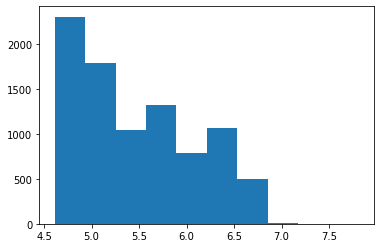

In [52]:
plt.hist(mu_post)

In [ ]:
"""
parameters = {'B': array([[0.07177631],
        [0.07214579],
        [0.02697002],
        [0.03161949],
        [0.02467784],
        [0.03341922],
        [0.07176589],
        [0.08871475]]),
 'b': 7.037519546355625,
 'q': 0.30325946457835395,
 'sd_prior': 3.313766807141957,
 'tau': 9}
"""

Define variables for analysis with penalties

In [ ]:
parameters = initialize_parameters(X_test,1,10)
derivatives,grads = initialize_dicts()

X = X_train
y = np.array(y_train)
mu_ra = np.array(risk_assess_train)
theta = 5
num_int = 100
learning_rate = 0.001
k = 1

In [ ]:
parameters

In [ ]:
loss = []
j = 0

while j < num_int:
    
    var_prior = parameters['var_prior'][0]
    q = parameters['q'][0]
    tau = parameters['tau']
        
    mu_prior = calc_prior_mean(X, parameters)[0]
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post, var_post, tau)
    L = calc_L(Phi, y, mu_prior, k)
    loss.append(np.sum(L))
        
    if j%%5==0:
        print(L)
        
    derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
    grads = calc_gradients(grads, derivatives, mu_prior, X)
    parameters = update_parameters(parameters, grads, learning_rate)
    
    j+=1
        


In [ ]:
loss

In [ ]:
loss = []

var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
print("B: ",parameters['B'])
print("b: ",parameters['b'])
print("q: ",parameters['q'])
print("var_prior: ",parameters['var_prior'])
print("tau: ",parameters['tau'])
print("loss: ",loss)
print("mu_prior: ",np.min(mu_prior),"to",np.max(mu_prior))
print("mu_post: ",np.min(mu_post),"to",np.max(mu_post))
print("Phi: ", np.min(Phi),"to",np.max(Phi))

In [ ]:
parameters

In [ ]:
var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

In [ ]:
mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)

In [ ]:
mu_prior

In [ ]:
test1 = 10*((1-mu_prior)**3)
test2 = y_train*np.log(1-Phi)+(1-y)*np.log(Phi)
test = test1 + test2
test

In [ ]:
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
parameters

In [ ]:
derivatives

In [ ]:
"""
# Predict test/train set examples 
#y_pred_train = predict(parameters,X_train,y_train,risk_assess_train,theta=5)
#y_pred_test = predict(parameters,X_test,y_test,risk_assess_test,theta=5)

# Print train/test Errors
# general accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

# confusion matrix
confmat = []

for true,pred in zip(y_train,y_pred_train):
    if(true==1 and pred==1):
        confmat.append("tp")
    elif(true==1 and pred==0):
        confmat.append("fn")
    elif(true==0 and pred==0):
        confmat.append("tn")
    else:
        confmat.append(fp)

print("true positives: ",confmat.count('tp'))
print("false positives: ",confmat.count('fp'))
print("true negatives: ",confmat.count('tn'))
print("false negatives: ",confmat.count('fn'))

if (confmat.count('tp')+confmat.count('fn'))>0:
    print("sensitivity/recall: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fn')))
else:
    print("sensitivity/recall: N/A")
    
if (confmat.count('tn')+confmat.count('fp'))>0:
    print("specificity: ",confmat.count('tn')/(confmat.count('tn')+confmat.count('fp')))
else:
    print("specificity: N/A")
    
if (confmat.count('tp')+confmat.count('fp'))>0:
    print("precision: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fp')))
else:
    print("precision: N/A")
    
model_dict = {"nLL": L,
              "y_pred_test": y_pred_test,
              "y_pred_train" : y_pred_train,
              "parameters" : parameters
              "learning_rate" : learning_rate,
              "num_iterations": num_iterations}

#return model_dict
"""

In [ ]:
def training_model(X,y,parameters,mu_ra,theta,num_int,learning_rate,k):
    
    mu_ra = np.array(mu_ra)
    y=np.array(y)
    loss = []
    j = 0
    
    while j < num_int:
        
        var_prior = parameters['var_prior'][0]
        q = parameters['q'][0]
        tau = parameters['tau']
        
        mu_prior = calc_prior_mean(X, parameters)[0]
        mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
        var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
        Phi = calc_Phi(mu_post, var_post, tau)
        L = calc_L(Phi, y, mu_prior, k)
        loss.append(np.sum(L))
        
        derivatives = calc_component_derivs(X, parameters, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
        grads = calc_gradients(derivatives, mu_prior, X)
        parameters = update_parameters(parameters, grads, learning_rate)
        #print(parameters)
        j+=1
        
    return loss, parameters, derivatives, grads

In [ ]:
def predict(parameters,X,y,risk_assess,theta):
    
    tau = parameters['tau']
    q = parameters['q']
    mu_ra = np.array(risk_assess)
    mu_prior = calc_prior_mean(X,parameters)[0]
    var_prior = parameters['var_prior']
    #var_ra = calc_var_ra(var_prior,mu_prior,mu_ra,q,theta)
    
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post,var_post,tau)
    #L = calc_L(Phi,y)
    
    y_pred = [1 if Phi[i]>0.5 else 0 for i in range(len(Phi))]
    
    return y_pred